Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Initial Burning Period
Training Start
Episode  100
Episode  200
Episode  300
Episode  400
Episode  500
Episode  600
Episode  700
Episode  800
Episode  900
Episode  1000
Episode  1100
Episode  1200
Episode  1300
Episode  1400
Episode  1500
Episode  1600
Episode  1700
Episode  1800
Episode  1900
Episode  2000
Episode  2100
Episode  2200
Episode  2300
Episode  2400
Episode  2500
Episode  2600
Episode  2700
Episode  2800
Episode  2900
Episode  3000
Episode  3100
Episode  3200
Episode  3300
Episode  3400
Episode  3500
Episode  3600
Episode  3700
Episode  3800
Episode  3900
Episode  4000
Episode  4100
Episode  4200
Episode  4300
Episode  4400
Episode  4500
Episode  4600
Episode  4700
Episode  4800
Episode  4900
Episode  5000
Episode  5100
Episode  5200
Episode  5300
Episode  5400
Episode  5500
Episode  5600
Episode  5700
Episode  5800
Episode  5900
Episode  6000
Episode  6100
Episode  6200
Episode  6300
Episode  6400
Epi

0.993


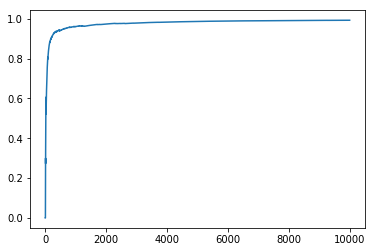

update_title_pos
update_title_pos
update_title_pos
update_title_pos


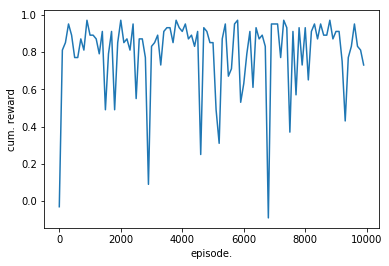

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import deque, namedtuple
import logging

from dqn_env import ENVIRONMENT
from dqn_ops import one_hot_encode

# this line is not needed in py file
%matplotlib inline
# this line is not needed in py file

np.random.seed(0)
random.seed(0)

logging.basicConfig(level=logging.DEBUG, format='%(message)s')

""" Hyper Parameters """
gamma = 0.99
max_episodes = 10000
memory_size = 1000
num_burning_episode = 100
batch_size = 32
copy_period = 100
test_period = 100
epsilon_test = 0.00

""" Environment """
env = ENVIRONMENT()
exp = namedtuple('experience', ['state', 'action', 'reward', 'next_state', 'done'])

""" Q-net and target Q-net """
W = np.random.uniform(0.0, 1.0, [env.num_states, env.num_actions])
W_target = deepcopy(W)

""" Replay Memory"""
replay_memory = deque(maxlen=memory_size)

""" Burning Period """
logging.info('Initial Burning Period')
for _ in range(num_burning_episode):
    env.current_state, env.done = env.reset()
    
    while not env.done:
        # we take random action so that
        # samples are less correlated
        # initially these samples will fill the replay memory
        action = env.random_action() # this is random action
        env.reward, next_state, env.done, _, _ = env.step(action)
        
        sample = exp(state=env.current_state, \
                     action=action, \
                     reward=env.reward, \
                     next_state=next_state,\
                     done=env.done)
        replay_memory.append(sample)

        env.current_state = next_state

""" Training """
logging.info('Training Start')
train_step = 0
cum_return_test = []
step_history = []
for episode_num in range(max_episodes):
    # Reset Environment and Reset Cum. Reward
    env.current_state, env.done = env.reset()

    learning_rate = 1. / ((episode_num * 0.1) + 1.)
    epsilon = 1. / ((episode_num * 0.1) + 1.)

    while not env.done:
        
        # Action Selection
        if np.random.uniform(0.,1.) > epsilon:
            state_one_hot = one_hot_encode([env.current_state], env.num_states) # rank 2
            action = np.argmax(state_one_hot @ W)
        else:
            action = env.random_action() # random action
            
        env.reward, next_state, env.done, _, _ = env.step(action)

        sample = exp(state=env.current_state, \
                     action=action, \
                     reward=env.reward, \
                     next_state=next_state, \
                     done=env.done)
        replay_memory.append(sample)
        
        env.current_state = next_state

        # Sample scenarios from replay-memory.
        samples = random.sample(replay_memory, batch_size)

        states_ = [sample.state for sample in samples]
        actions_ = [sample.action for sample in samples]
        rewards_ = [sample.reward for sample in samples]
        next_states_ = [sample.next_state for sample in samples]
        dones_ = [sample.done for sample in samples]

        states = one_hot_encode(states_, env.num_states) # rank 2
        actions = one_hot_encode(actions_, env.num_actions) # rank 2
        rewards = np.reshape(np.array(rewards_, dtype=np.float32), (-1, 1))
        next_states = one_hot_encode(next_states_, env.num_states) # rank 2
        dones = np.reshape(np.array(dones_, dtype=np.float32), (-1, 1))

        # Make target for Q-net.
        #q_target_max = np.amax(np.matmul(next_states, W_target), axis=1, keepdims=True)
        targets_not_done = rewards \
                           + gamma \
                           * np.amax(np.matmul(next_states, W_target), axis=1, keepdims=True) # (32,1)
        targets_done = rewards # (32,1)
        targets = (1.0 - dones) * targets_not_done + dones * targets_done

        # Weight Update
        q_val = np.sum(np.matmul(states, W) * actions, axis=1, keepdims=True) # (32,1)
        gradient = np.reshape((targets - q_val), [-1]) # negative gradient up to constant multiplication 
        # you have to choose one of the following three update rule
        if 0:
            # this implementation is wrong
            W[states_, actions_] += learning_rate * gradient
        elif 0:
            # this implementation is correct
            # but, not good for reading
            for i in range(batch_size):
                W[states_[i], actions_[i]] += learning_rate * gradient[i]
        elif 1:
            dW = np.zeros(W.shape)
            for i in range(batch_size):
                dW[states_[i], actions_[i]] += gradient[i]
            W += learning_rate * dW

        train_step += 1 # count gradient descent update

        # Network Synchronization
        if train_step % copy_period == 0:
            W_target = deepcopy(W)

        # Terminal of Scenario.
        if env.done:
            if env.current_state == env.win_state:
                step_history.append(1)
            if env.current_state == env.lose_state:
                step_history.append(0)
            break

    if (episode_num + 1) % 100 == 0:
        logging.info('Episode  %d' % (episode_num+1))

    """ Test """
    if episode_num % test_period == 0:
        env.current_state, env.done = env.reset()
        cum_rwd = 0.0

        while not env.done:
            
            # Action Selection
            if np.random.uniform(0.,1.) > epsilon_test:
                state_one_hot = one_hot_encode([env.current_state], env.num_states) # rank 2
                action = np.argmax(state_one_hot @ W)
            else:
                action = env.random_action()

            env.reward, next_state, env.done, _, _ = env.step(action)
            cum_rwd += env.reward
            
            if cum_rwd < -10.:
                break

            env.current_state = next_state

        cum_return_test.append(cum_rwd)

fig = plt.figure(1)
history = np.cumsum(step_history) / (np.arange(max_episodes) + 1)
print(history[-1])
plt.plot(history)
plt.show()

fig = plt.figure(2)
plt.plot(np.arange(len(cum_return_test)) * test_period, cum_return_test)
plt.xlabel('episode.')
plt.ylabel('cum. reward')
plt.show()